### What does the radio for 'Waiting For You' look like without any previous listening history?
- New Spotify account created + web API required

In [1]:
!pip3 install spotipy

import os
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
!pip3 install spotipy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import defaultdict
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics.pairwise import cosine_similarity as cosine

In [5]:
# Authentication 
SPOTIFY_CLIENT_ID ='d88e91cf58d74adcabe30d5d781f2685'
SPOTIFY_CLIENT_SECRET = 'ec30c7b97f5f4e438a2200e8f3ffe428'

auth_manager = SpotifyClientCredentials(SPOTIFY_CLIENT_ID,SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Outline target song 
song_name = ' Waiting For You (feat. Naomi Sharon) '
artist_name = ' Majid Jordan (feat Naomi Sharon)'

results = sp.search(q=f'track:{song_name} artist:{artist_name}', limit=1, type='track')
if results['tracks']['items']:
    track_id = results['tracks']['items'][0]['id']
else:
    print('x')

# Retrieve a sample of playlists with the chosen song as a radio
playlists = sp.search(q=f'track:{song_name} artist:{artist_name}', type='playlist')
track_data = []
print(playlists)

{'playlists': {'href': 'https://api.spotify.com/v1/search?query=track%3A+Waiting+For+You+%28feat.+Naomi+Sharon%29++artist%3A+Majid+Jordan+%28feat+Naomi+Sharon%29&type=playlist&offset=0&limit=10', 'items': [{'collaborative': False, 'description': 'With dvsn, Roy Woods, Ramriddlz and more', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1E4k3kpnSrSHNR'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1E4k3kpnSrSHNR', 'id': '37i9dQZF1E4k3kpnSrSHNR', 'images': [{'height': None, 'url': 'https://seeded-session-images.scdn.co/v2/img/540/r/artist/4HzKw8XcD0piJmDrrPRCYk/en', 'width': None}], 'name': 'Majid Jordan Radio', 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTcxNzYzMTg1OSwwMDAwMDAwMGM5OWZiYzU2MzI2OWEwYzkxOTUzYTBkZjI4NDQzY2Rh

In [6]:
# Iterate through the search results, finding all playlist data available.
for playlist in playlists['playlists']['items']:
    # Get the playlist ID
    playlist_id = playlist['id']
    
    # Retrieve tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id)

    # Instatiate a dictionary for the results to be stored
    track_ids = []
    
    # Iterate through the tracks in the playlist
    for item in playlist_tracks['items']:
        track = item['track']
        # Extract track information
        track_name = track['name']
        track_artist = ', '.join([artist['name'] for artist in track['artists']])
        track_album = track['album']['name']
        track_popularity = track['popularity']
        
        # Retrieve genre information for each artist
        artist_ids = [artist['id'] for artist in track['artists']]
        artist_genres = []
        for artist_id in artist_ids:
            artist_info = sp.artist(artist_id)
            artist_genres.extend(artist_info['genres'])
        artist_genres = list(set(artist_genres))  # Remove duplicates
        genres_str = ', '.join(artist_genres)
        
        audio_features = sp.audio_features(track['id'])[0] # The following column names were outlines and extracted from Spotify's API documentation, available at: https://developer.spotify.com/documentation/web-api.
        track_data.append({
            'playlist_name': playlist['name'],
            'track_id': track['id'],
            'track_name': track_name,
            'track_artist': track_artist,
            'track_album': track_album,
            'track_popularity': track_popularity,
            'track_genres': genres_str,
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'key': audio_features['key'],
            'loudness': audio_features['loudness'],
            'mode': audio_features['mode'],
            'speechiness': audio_features['speechiness'],
            'acousticness': audio_features['acousticness'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'valence': audio_features['valence'],
            'tempo': audio_features['tempo'],
            'duration_ms': audio_features['duration_ms'],
            'time_signature': audio_features['time_signature'] })
       

df = pd.DataFrame(track_data)
df # Print

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,53,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,78,"rap, r&b, melodic rap, trap",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
2,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,84,"lgbtq+ hip hop, neo soul",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,75,"rap, r&b, kentucky hip hop",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3pXF1nA74528Edde4of9CC,Don't,Bryson Tiller,T R A P S O U L,83,"rap, r&b, kentucky hip hop",0.765,0.356,11,-5.556,0,0.1950,0.22300,0.000000,0.0963,0.1890,96.991,198293,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,WAIT FOR U (feat. Drake & Tems) Radio,0k7wmahjkn389wAZdz19Cv,Drankin N Smokin,"Future, Lil Uzi Vert",Pluto x Baby Pluto,70,"melodic rap, southern hip hop, atl hip hop, ph...",0.752,0.658,0,-6.297,1,0.3420,0.04210,0.000000,0.0927,0.3870,151.951,213520,4
544,WAIT FOR U (feat. Drake & Tems) Radio,67nepsnrcZkowTxMWigSbb,MELTDOWN (feat. Drake),"Travis Scott, Drake",UTOPIA,79,"rap, pop rap, hip hop, canadian hip hop, canad...",0.557,0.774,7,-5.275,0,0.3510,0.01200,0.000000,0.3960,0.3970,111.975,246134,4
545,WAIT FOR U (feat. Drake & Tems) Radio,4Q34FP1AT7GEl9oLgNtiWj,Mr. Right Now (feat. Drake),"21 Savage, Metro Boomin, Drake",SAVAGE MODE II,68,"atl hip hop, rap, pop rap, hip hop, canadian h...",0.647,0.667,5,-5.563,1,0.3040,0.23100,0.000000,0.1330,0.7040,172.080,193839,4
546,WAIT FOR U (feat. Drake & Tems) Radio,3XgGQ1wjo5khvq2UImjyNF,ALL MINE,Brent Faiyaz,WASTELAND,76,"rap, r&b",0.617,0.378,9,-8.540,1,0.0315,0.42800,0.000092,0.1100,0.2200,141.967,216063,4


In [7]:
# Removing NaN values before clustering. Although this significantly drops the overall dataset by roughly 50%
df = df.drop_duplicates(subset=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])
df = df.dropna(subset=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])
df

,playlist_name,track_id,track_name,track_artist,track_album,track_popularity,track_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Majid Jordan Radio,4Wfe2jloKo95eFVnJEr5N1,Her,Majid Jordan,A Place Like This,53,"canadian contemporary r&b, canadian hip hop",0.676,0.500,1,-6.603,1,0.0513,0.00371,0.002780,0.1140,0.0742,90.030,300729,4
1,Majid Jordan Radio,2pg2TiYo9Rb8KeB5JjP7jS,Sativa,"Jhené Aiko, Swae Lee",Trip,78,"rap, r&b, melodic rap, trap",0.741,0.610,6,-7.340,0,0.0511,0.31600,0.000000,0.5340,0.7200,125.990,276960,4
2,Majid Jordan Radio,7DfFc7a6Rwfi3YQMRbDMau,Thinkin Bout You,Frank Ocean,channel ORANGE,84,"lgbtq+ hip hop, neo soul",0.721,0.339,0,-11.195,1,0.0532,0.40900,0.001530,0.0973,0.2000,129.830,200747,4
3,Majid Jordan Radio,6oEVnWKgPqIEPc53OYDNqG,Could've Been (feat. Bryson Tiller),"H.E.R., Bryson Tiller",I Used To Know Her,75,"rap, r&b, kentucky hip hop",0.450,0.352,1,-11.733,0,0.2670,0.64900,0.000004,0.2490,0.4080,102.679,252747,4
4,Majid Jordan Radio,3pXF1nA74528Edde4of9CC,Don't,Bryson Tiller,T R A P S O U L,83,"rap, r&b, kentucky hip hop",0.765,0.356,11,-5.556,0,0.1950,0.22300,0.000000,0.0963,0.1890,96.991,198293,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,WAIT FOR U (feat. Drake & Tems) Radio,0k7wmahjkn389wAZdz19Cv,Drankin N Smokin,"Future, Lil Uzi Vert",Pluto x Baby Pluto,70,"melodic rap, southern hip hop, atl hip hop, ph...",0.752,0.658,0,-6.297,1,0.3420,0.04210,0.000000,0.0927,0.3870,151.951,213520,4
544,WAIT FOR U (feat. Drake & Tems) Radio,67nepsnrcZkowTxMWigSbb,MELTDOWN (feat. Drake),"Travis Scott, Drake",UTOPIA,79,"rap, pop rap, hip hop, canadian hip hop, canad...",0.557,0.774,7,-5.275,0,0.3510,0.01200,0.000000,0.3960,0.3970,111.975,246134,4
545,WAIT FOR U (feat. Drake & Tems) Radio,4Q34FP1AT7GEl9oLgNtiWj,Mr. Right Now (feat. Drake),"21 Savage, Metro Boomin, Drake",SAVAGE MODE II,68,"atl hip hop, rap, pop rap, hip hop, canadian h...",0.647,0.667,5,-5.563,1,0.3040,0.23100,0.000000,0.1330,0.7040,172.080,193839,4
546,WAIT FOR U (feat. Drake & Tems) Radio,3XgGQ1wjo5khvq2UImjyNF,ALL MINE,Brent Faiyaz,WASTELAND,76,"rap, r&b",0.617,0.378,9,-8.540,1,0.0315,0.42800,0.000092,0.1100,0.2200,141.967,216063,4


In [11]:
# Standardize features then implement into a K-means cluster. This aids in the analysis between playlists.
scaler = StandardScaler()
features = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
scaled_features = scaler.fit_transform(features)


cluster                                      0  1   2   3   4
playlist_name                                                
Coco Jones Radio                             0  1  14   9  16
Jordan Ward Mix                              0  4  20   6  17
Love Deluxe                                  1  6  26   0  17
Majid Jordan Mix                             0  2   5   3   5
Majid Jordan Radio                           0  7  16   6  21
Majid Jordan: THE PLAYLIST                  15  8  19   5  45
Mix Majid Almohandis                         0  9  14   3  24
This Is Majid Jordan                         2  1   9   2  11
WAIT FOR U (feat. Drake & Tems) Radio        3  3   9  18  13
Waiting For You (feat. Naomi Sharon) Radio   6  1  22   4   8


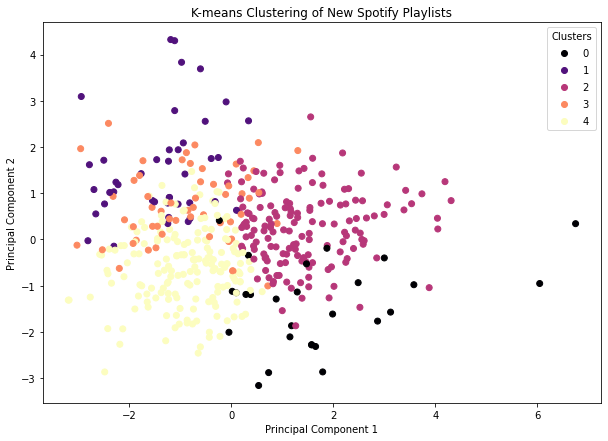

In [15]:
# K-Means Clustering for new Spotify account: 

kmeans = KMeans(n_clusters=5, n_init=10, random_state=42) # chose 5 clusters 
df.loc[:, 'cluster'] = kmeans.fit_predict(scaled_features)

# Analyze clusters
clustered_playlists = df.groupby(['playlist_name', 'cluster']).size().unstack(fill_value=0)
print(clustered_playlists)

# Apply PCA to reduce to feature values to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df['pc1'] = principal_components[:, 0]
df['pc2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['pc1'], df['pc2'], c=df['cluster'], cmap='magma')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of New Spotify Playlists')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()




In [ ]:
# Cosine similarity

features_df = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Calculate cosine similarity
similarities = cosine(waiting_for_you_scaled, features_scaled)

# Convert similarities to a DataFrame for easier handling
similarities_df = pd.DataFrame(similarities, columns=df.index, index=['Waiting For You'])